In [1]:
from scipy.ndimage import watershed_ift
from skimage.segmentation import watershed
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_closing, binary_opening
from skimage.measure import label
from skimage.segmentation import mark_boundaries

from src.data.monuseg.tf_data import get_dataset 
from src.models.monuseg.metrics import f_score, aggregated_jaccard_index

In [2]:
result = np.load("/home/valentin/python_wkspce/2d_bispectrum_cnn/test.npy.npz")


In [3]:
image_ids_test = [
    'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1',
    'TCGA-B0-5698-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1'
]
ds = get_dataset(id_list=image_ids_test, instance=True)

In [4]:
xx, y_true = next(ds.as_numpy_iterator())

In [5]:
x = result['x']
y_pred = result['y_pred']
y_true_3classes = result['y_true']

In [8]:
y_true.shape

(1000, 1000, 1)

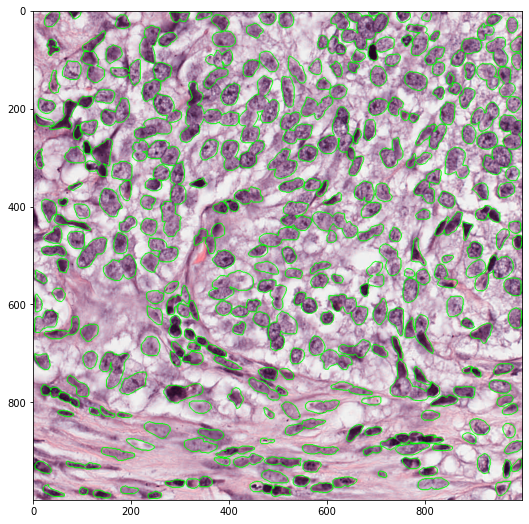

In [9]:
plt.figure(figsize=(9, 9))
image_annotated = mark_boundaries(
    x[0,...],
    y_true[...,0] !=0,
    color=(0, 1, 0),
    mode="thick"
)
plt.imshow(image_annotated)

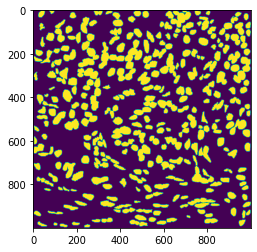

In [12]:
plt.imshow(y_true[...,0] > 0.5)


In [13]:
def predict_monuseg(y_pred):
    y_pred_quantized = (y_pred > 0.5).astype(np.uint8)
    # y_pred_quantized = np.zeros_like(y_pred, dtype=np.uint8)
    # y_pred_quantized[..., 1] = (y_pred[..., 1] > 0.5).astype(np.uint8)
    # y_pred_quantized[..., 0] = (y_pred[..., 0] > 0.5).astype(np.uint8)
    # y_pred_quantized[..., 2] = (y_pred[..., 2] > 0.5).astype(np.uint8)
    batch_size = y_pred.shape[0]
    output = list()
    for s in range(batch_size):
        markers = label(y_pred_quantized[s, :, :, 0])
        markers[y_pred_quantized[s, :, :, 2] != 0] = -1
        out = watershed_ift((y_pred_quantized[s, :, :, 1]).astype(np.uint8),
                            markers)
        out[out == -1] = 0
        output.append(out)
    return np.stack(output, axis=0)

In [14]:
def yo(y_pred):
    batch_size = y_pred.shape[0]
    output = list()
    for s in range(batch_size):
        output.append(
            label(
                binary_opening(y_pred[s, :, :, 0] > 0.5,
                               structure=np.ones((3, 3)),
                               iterations=2)))

    return np.stack(output, axis=0)


In [15]:
y_pred_pp = predict_monuseg(y_pred)
y_true_pp = predict_monuseg(y_true_3classes)

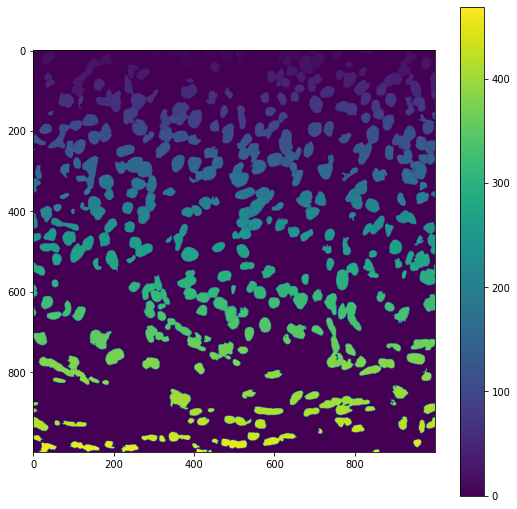

In [16]:
plt.figure(figsize=(9,9))
plt.imshow(y_pred_pp[0,...])
plt.colorbar()

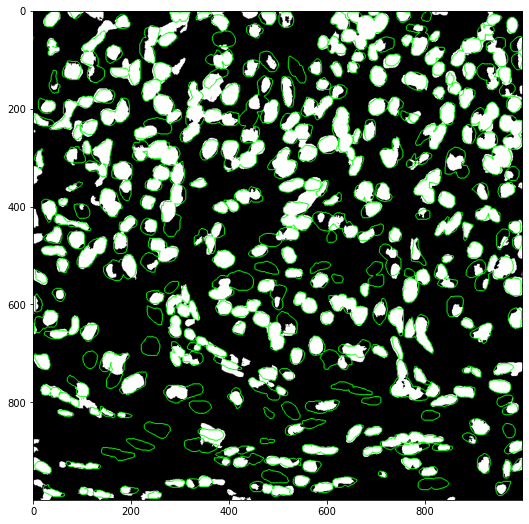

In [18]:
plt.figure(figsize=(9, 9))
image_annotated = mark_boundaries(y_pred_pp[0, ...]!=0,
                                  y_true[...,0] != 0,
                                  color=(0, 1, 0),
                                  mode="thick")
plt.imshow(image_annotated)

In [21]:
f_score(y_true[..., 0], y_true[..., 0])


1.0

In [20]:
aggregated_jaccard_index(y_true[...,0], y_pred_pp[0, ...])


0.4489673855680259

In [ ]:
mask = np.load("/home/valentin/python_wkspce/2d_bispectrum_cnn/data/raw/MoNuSeg2018Training/MasksV2_instance/binary/TCGA-18-5592-01Z-00-DX1.npy")

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(mask)

In [ ]:
mask.shape

In [ ]:
mask.astype(np.int64).dtype

In [ ]:
mask = np.load("/home/valentin/python_wkspce/2d_bispectrum_cnn/data/raw/MoNuSeg2018Training/MasksV2_instance/color/TCGA-18-5592-01Z-00-DX1.npy")

In [ ]:
np.min(mask)